In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, f1_score


In [68]:
#model options
def model_predictions(x, X_train, X_test, y_train, y_test):
    if x == "logistic":
        model = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear')
        model.fit(X_train, y_train)
        print("Logistic:")
        predictions =  model.predict(X_test)
    elif x == "knn":
        model = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
        model.fit(X_train, y_train)
        print("KNN:")
        predictions = model.predict(X_test)
    elif x=="decision_tree":
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        print("Decision Tree:")
        predictions = model.predict(X_test)
    elif x=="random_forest":
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        print ("Random Forest:")
        predictions = model.predict(X_test)
    else:
        print ("Input should be logistic, knn, decision_tree or random_forest")   
    
    #calculate scores. Kappa/ROC-AUC/F1 were chosen and should be as high as possible 0-1
    print("The accuracy of the model on test set is: ", accuracy_score(y_test, predictions)) 
    print("Kappa: ", cohen_kappa_score(y_test, predictions))   
    #print("ROC-AUC score: ", roc_auc_score(y_test, predictions, multi_class="ovr")) 
    print("F1 score: ", f1_score(y_test, predictions, average="weighted"))  
    #generate confusion matrices with raw and normalised values
    print ("Confusion Matrix - raw:")
    plot_confusion_matrix(model, X_test, y_test, cmap = "YlOrBr")
    plt.savefig('confusion_raw.png')
    plt.show() 
    
    print ("Confusion Matrix - normalised row-wise:")
    plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = "GnBu", values_format='.2f')
    plt.show() 
    return [model, predictions]

In [73]:
#read data
data = pd.read_csv("Dry_Bean_Dataset.csv")
data.head()

,Bean ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,1,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,2,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,3,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,4,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,5,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [74]:
data.shape

(13611, 18)

In [6]:
#drop unique identifier
data = data.drop(["Bean ID"], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [8]:
def clean_columns(x):
    x = x.lower().strip().replace(' ', '_')
    return x

data.columns = list(map(clean_columns, data.columns))
data.columns

Index(['area', 'perimeter', 'majoraxislength', 'minoraxislength',
       'aspectration', 'eccentricity', 'convexarea', 'equivdiameter', 'extent',
       'solidity', 'roundness', 'compactness', 'shapefactor1', 'shapefactor2',
       'shapefactor3', 'shapefactor4', 'class'],
      dtype='object')

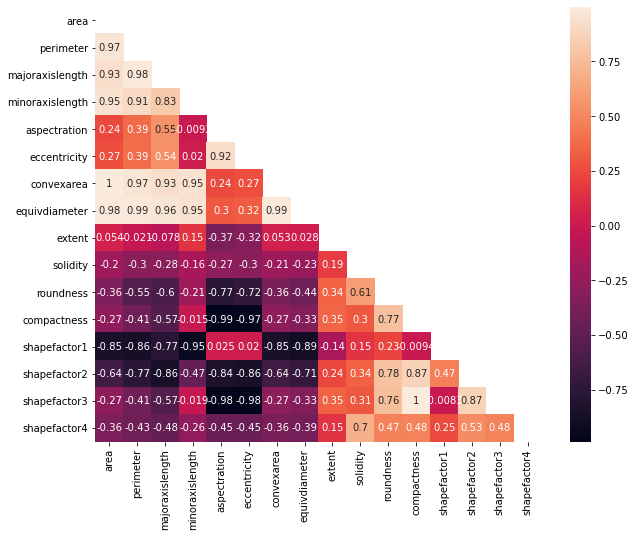

In [10]:
#num is all data except the bean class (target)
num = data.drop(["class"], axis=1)
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix) 
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [11]:
#drop some columns due to multicollinearity
data_edit = data.drop(["perimeter", "convexarea", "shapefactor3", "equivdiameter", 
                       "majoraxislength", "minoraxislength", "compactness", "shapefactor2", "eccentricity"], axis=1)

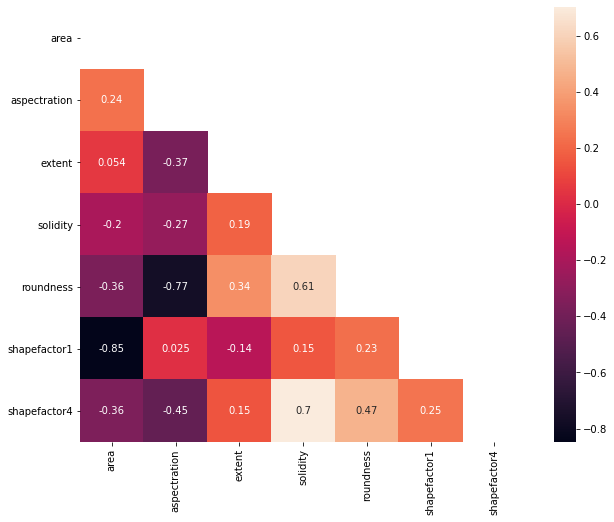

In [14]:
#checking multicollinearity again without above columns
num = data_edit.drop(["class"], axis=1)
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix) 
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [15]:
#also check variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif = {}
num_vif = num.copy()
num_vif= add_constant(num)

In [16]:
for i in np.arange(num_vif.shape[1]):
    column_name = num_vif.columns[i]
    value = variance_inflation_factor(np.array(num_vif), i)
    vif[column_name] = value
vif

#all values are low so no need to drop any more columns
data = data_edit.copy()

{'const': 82702.76194523077,
 'area': 4.900889756414435,
 'aspectration': 6.228380628971094,
 'extent': 1.22411628406107,
 'solidity': 4.706097957822616,
 'roundness': 7.045597677480644,
 'shapefactor1': 5.406009254925518,
 'shapefactor4': 3.4317805452578436}

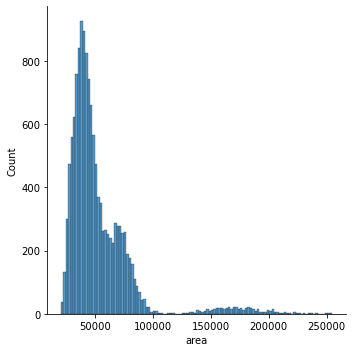

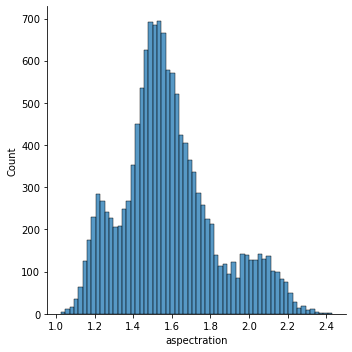

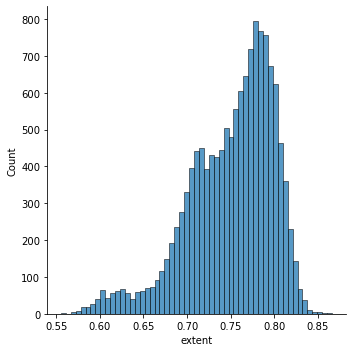

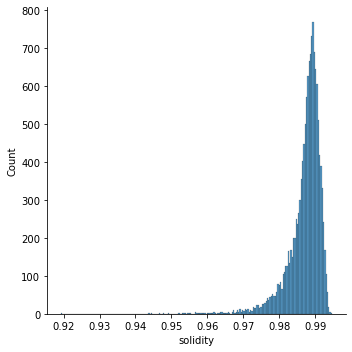

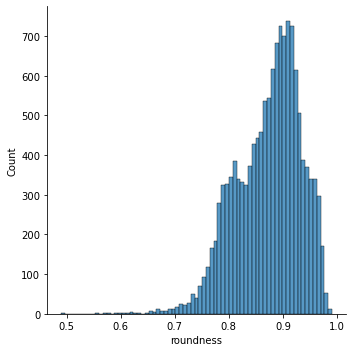

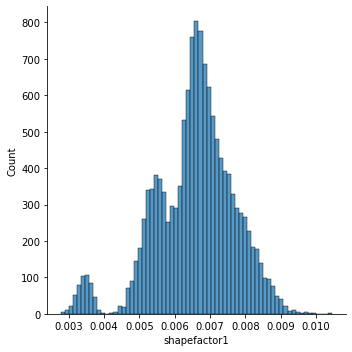

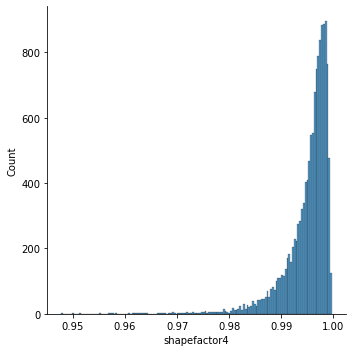

In [18]:
#check distributions of the data
for i in data.drop(["class"], axis=1):
    sns.displot(data[i])
    plt.show()

In [20]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  

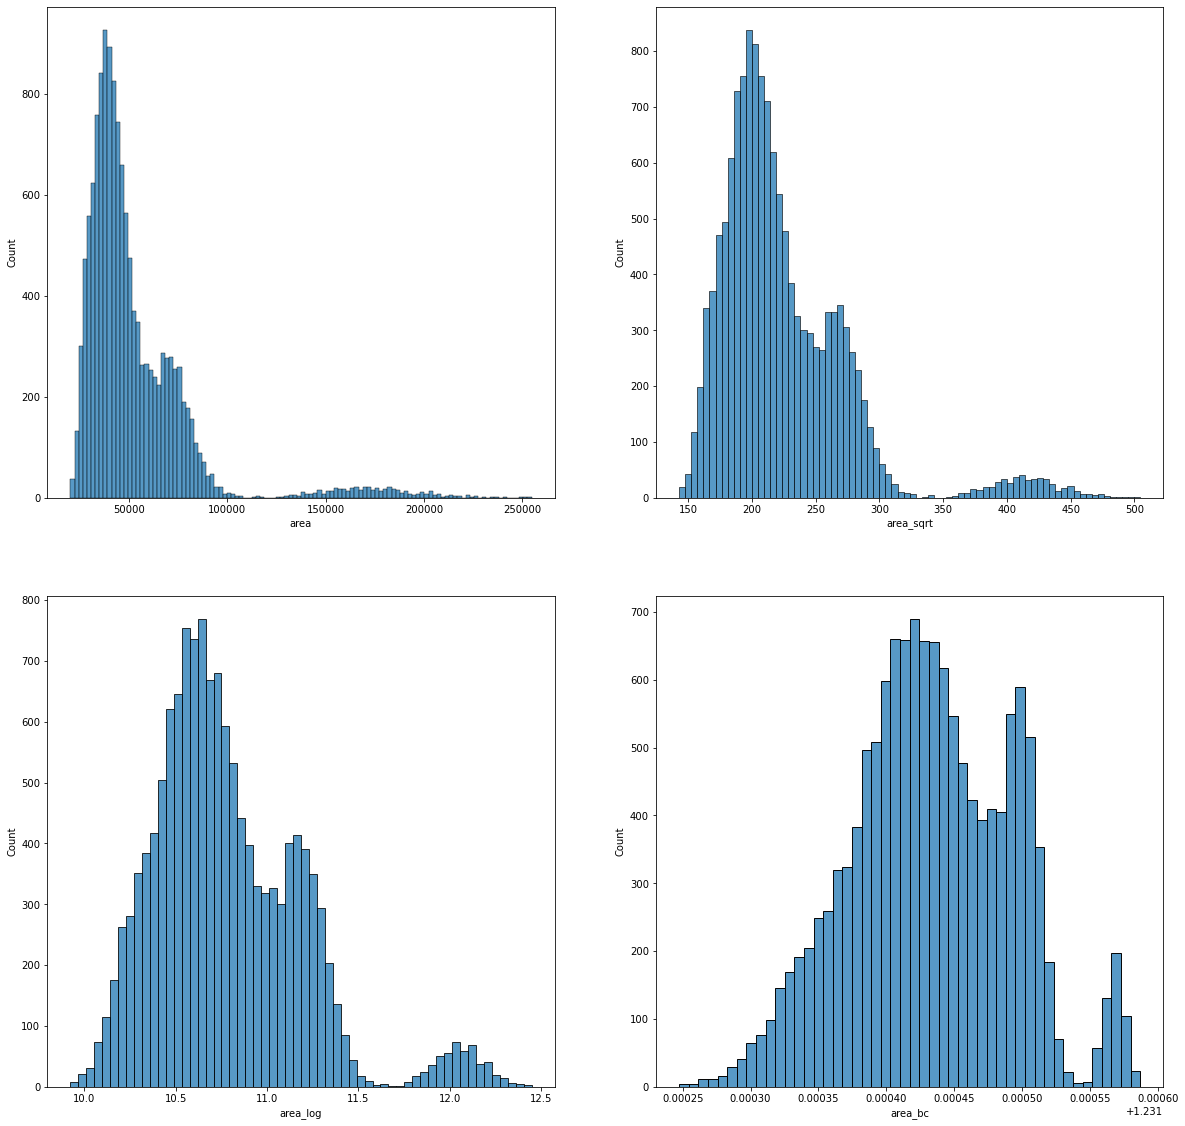

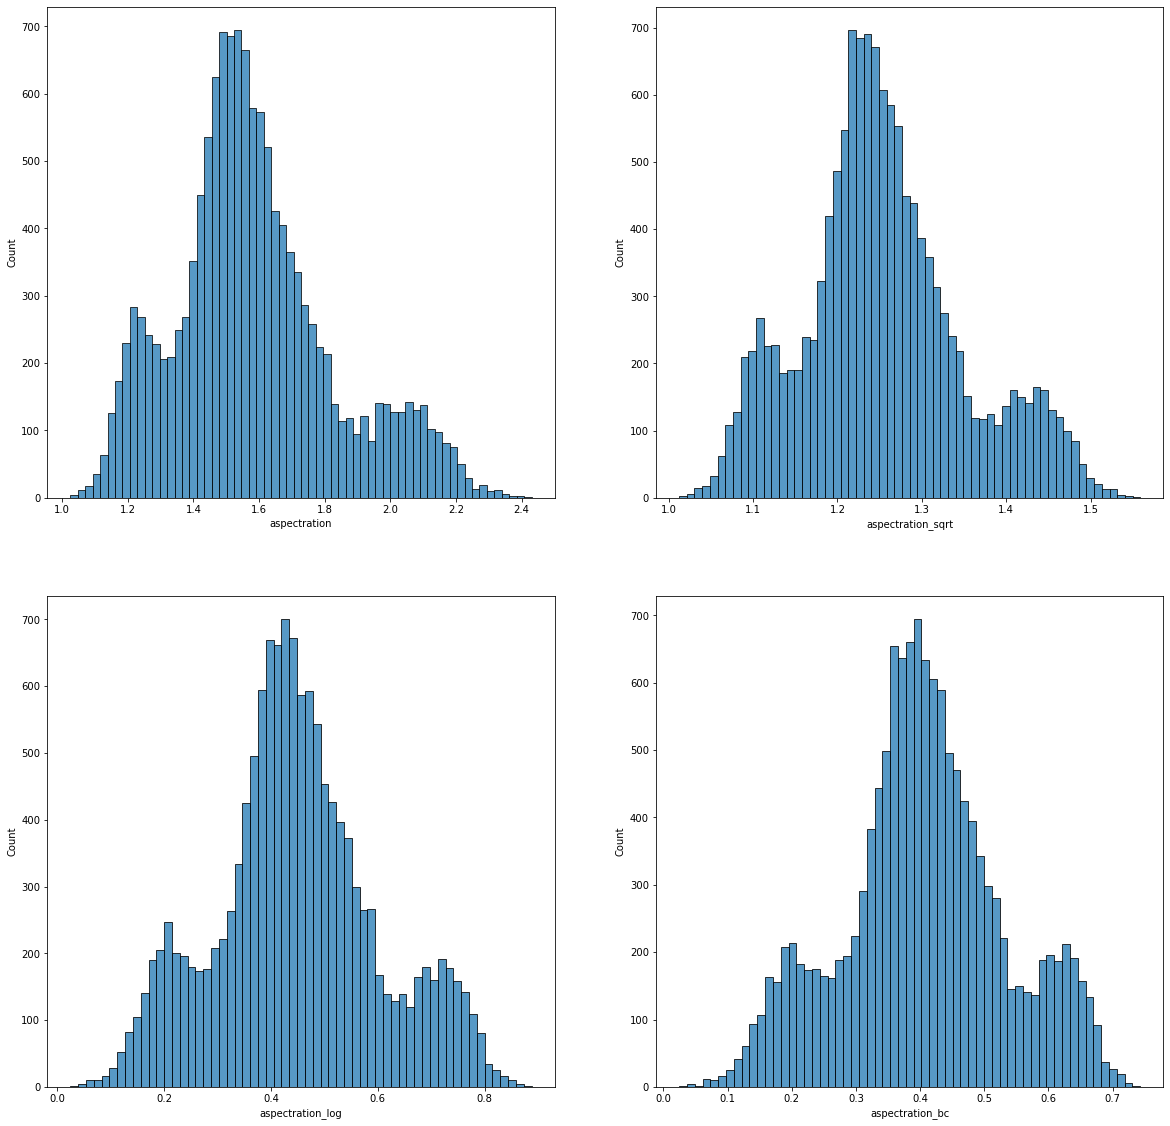

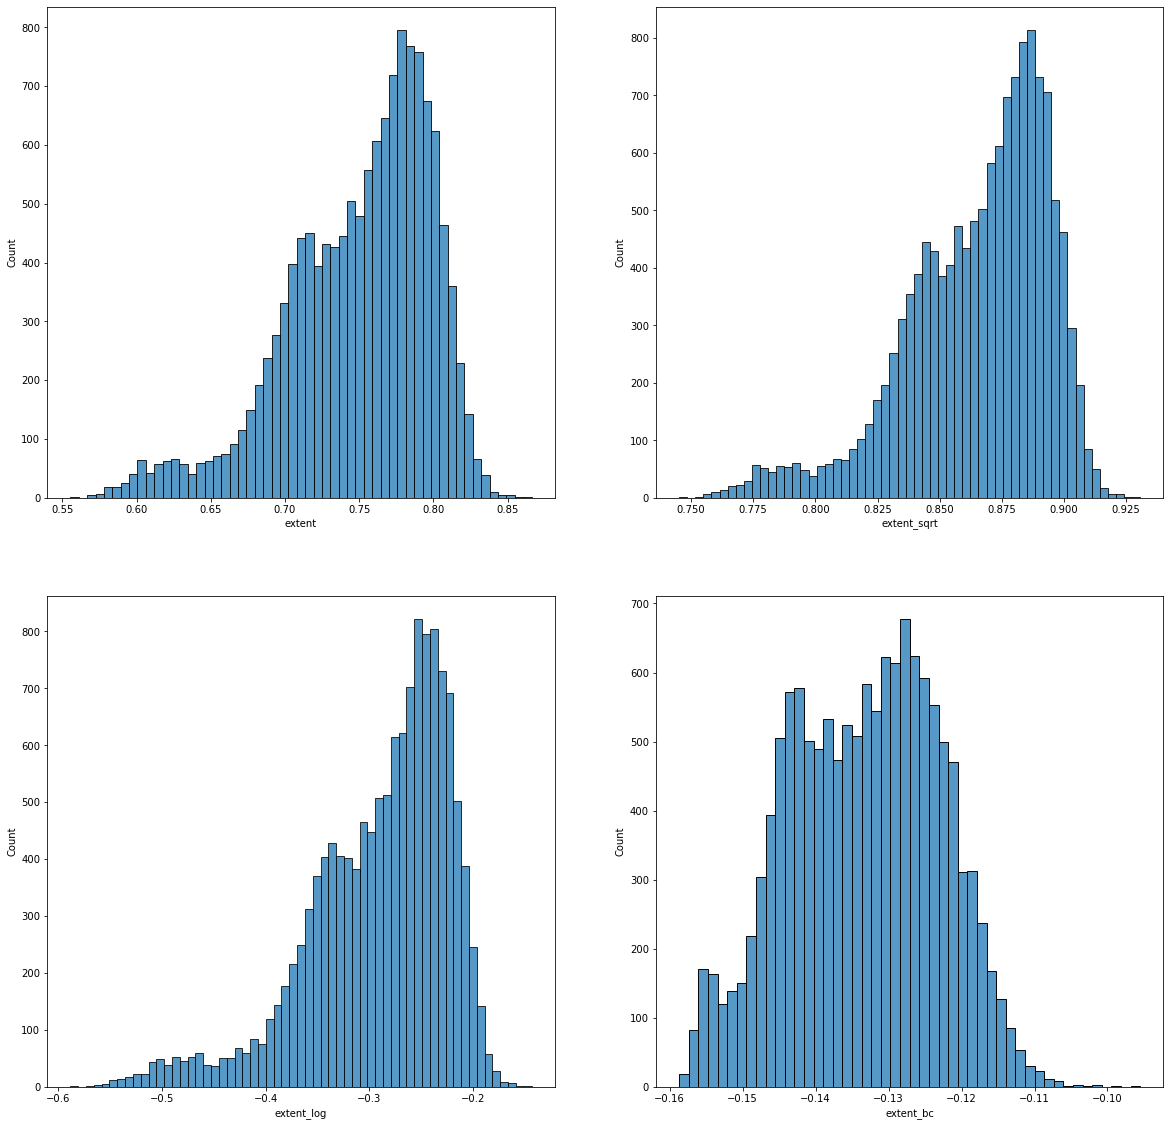

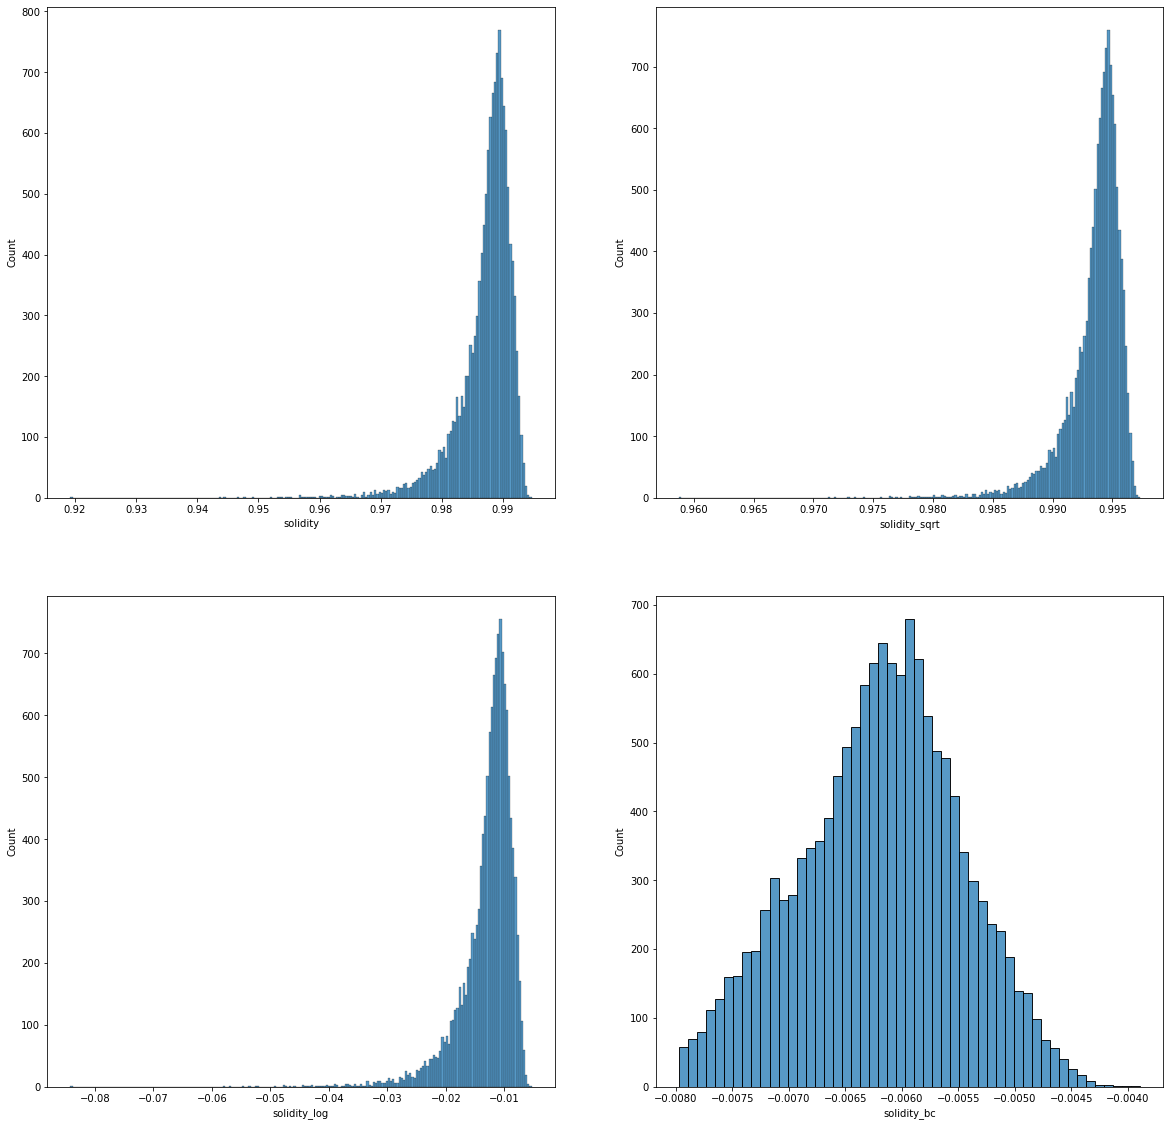

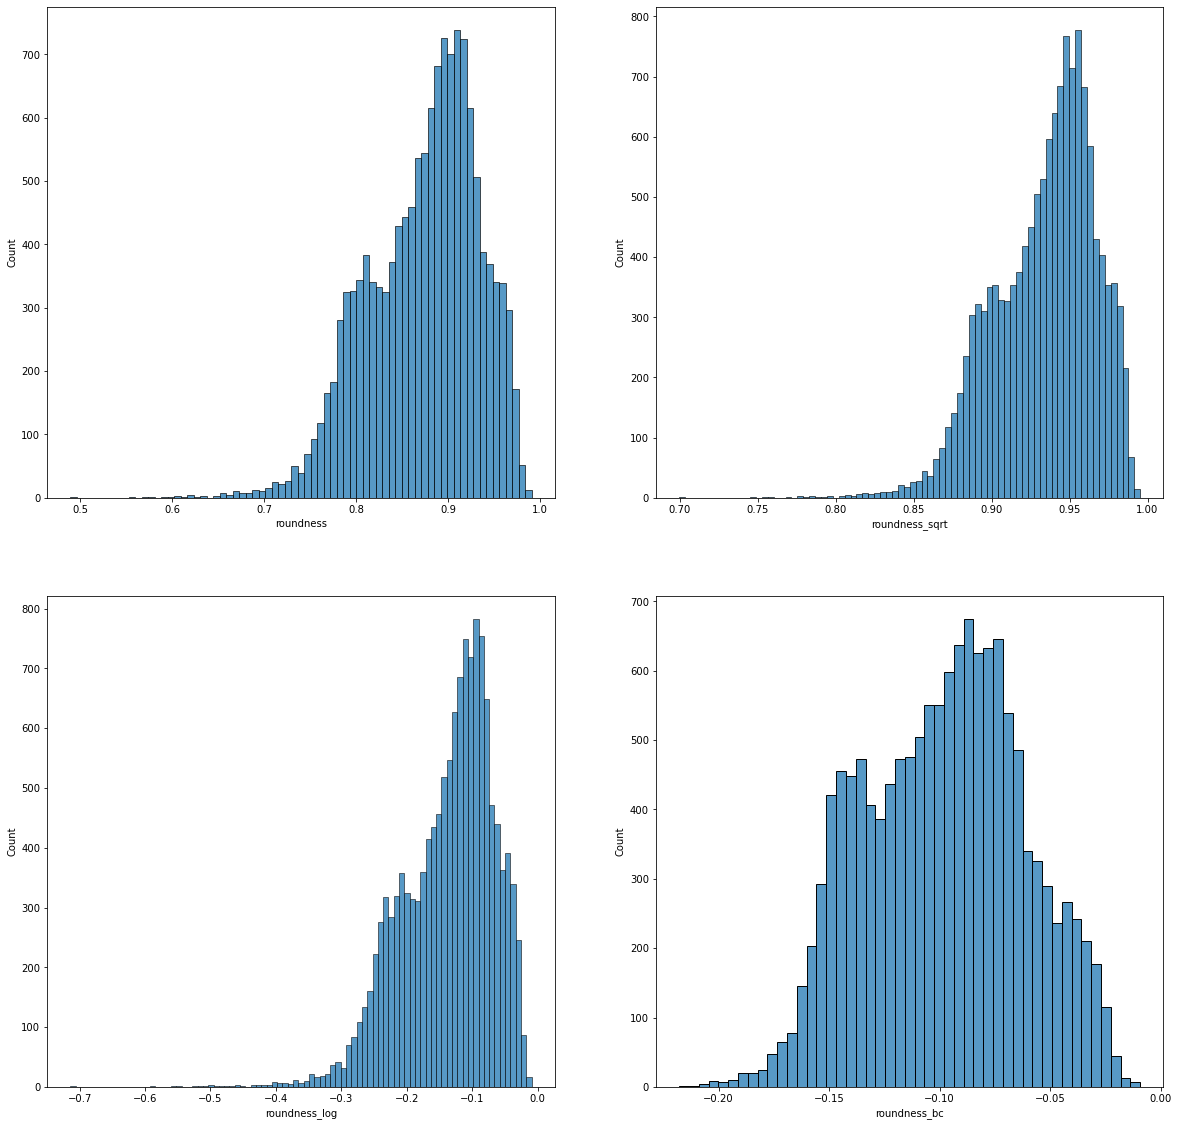

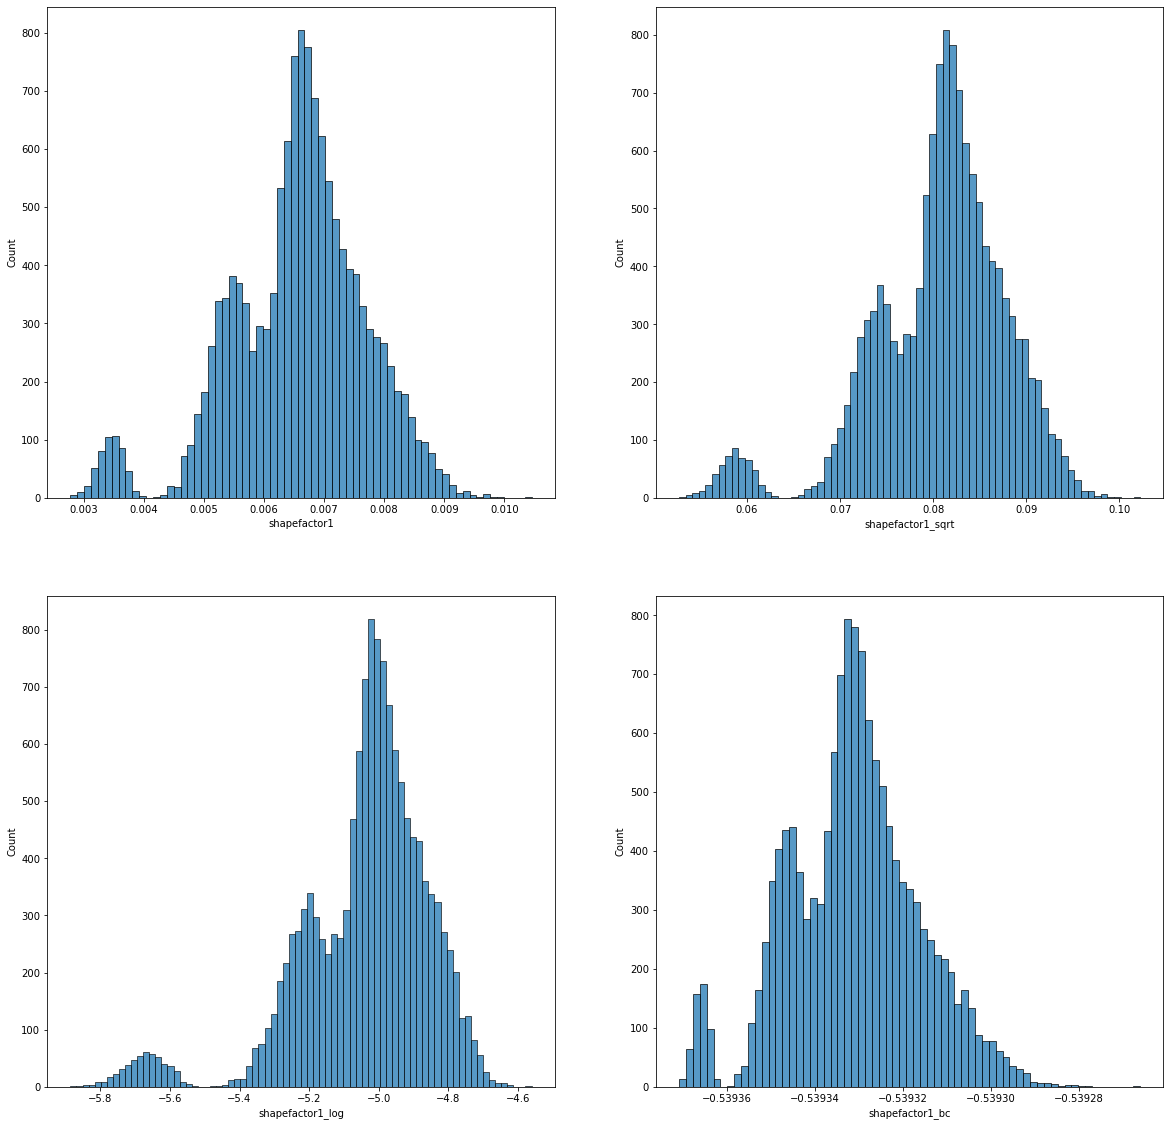

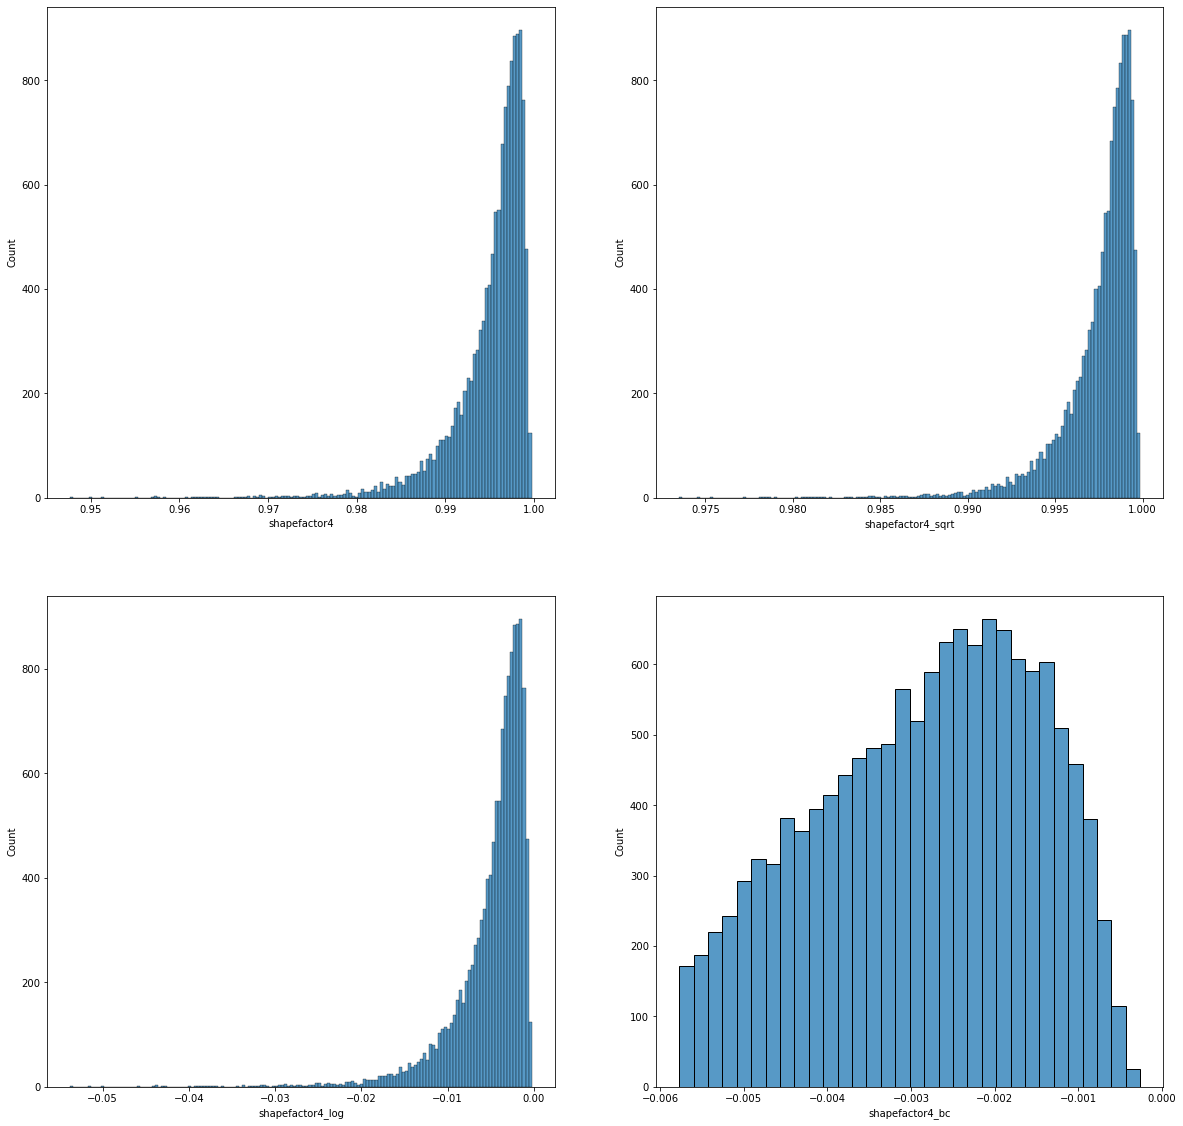

In [21]:
#check log, sqrt and boxcox distributions
for name in data.columns:
    if name != "class":
        if data[name].min() > 0:

            data[name+"_sqrt"] = data[name]**(1/2)
            data[name+"_log"] = list(map(log_transform_clean, data[name]))
            box_cox, lmbda = stats.boxcox(data[name])
            data[name+"_bc"]= box_cox

            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
            plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
            sns.histplot(data[name], ax=ax1)
            sns.histplot(data[name+"_sqrt"], ax=ax2)
            sns.histplot(data[name+"_log"], ax=ax3)
            sns.histplot(data[name+"_bc"], ax=ax4)
        else:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
            data[name+"_sqrt"] = data[name]**(1/2)
            data[name+"_log"] = list(map(log_transform_clean, data[name]))
            sns.histplot(data[name], ax=ax1)
            sns.histplot(data[name+"_sqrt"], ax=ax2)
            sns.histplot(data[name+"_log"], ax=ax3)
    else: continue
        
           

In [22]:
#choose boxcox option for all columns except shape factor 1 (use sqrt) as the closest to a normal distribution
data = data[["area_bc", "aspectration_bc", "extent_bc", "solidity_bc",
            "roundness_bc", "shapefactor1_sqrt", "shapefactor4_bc", "class"]]    

In [25]:
#define X and y for model
X=data.drop(["class"],axis=1)
y=data["class"]

In [26]:
mapping = {
        'SEKER': 0,
        'BARBUNYA': 1,
        'BOMBAY' : 2,
        'CALI' : 3,
        'HOROZ' : 4,
        'SIRA' : 5,
        'DERMASON' : 6
    }
y = y.replace(mapping)

In [27]:
#check data isn't imbalanced
y.value_counts()

6    3546
5    2636
0    2027
4    1928
3    1630
1    1322
2     522
Name: class, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=100)

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

transformer = StandardScaler().fit(X_train)
X_train_standardized = transformer.transform(X_train)
X_test_standardized = transformer.transform(X_test)

transformer2=Normalizer().fit(X_train)
X_train_normalized = transformer2.transform(X_train)
X_test_normalized = transformer2.transform(X_test)

In [30]:
#apply standardisation to train data
X_train_standardized = pd.DataFrame(X_train_standardized, index=X_train.index)
X_train_standardized.columns = X_train.columns

X_test_standardized = pd.DataFrame(X_test_standardized, index=X_test.index)
X_test_standardized.columns = X_test.columns


In [31]:
#apply normalisation to train data
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index)
X_train_normalized.columns = X_train.columns

X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index)
X_test_normalized.columns = X_test.columns

In [32]:
#choose whether to use standardized or normalized data
X_train = X_train_standardized
X_test = X_test_standardized

Random Forest:
The accuracy of the model on test set is:  0.928256611165524
Kappa:  0.9130544214573084
F1 score:  0.9283580024676145
Confusion Matrix - raw:


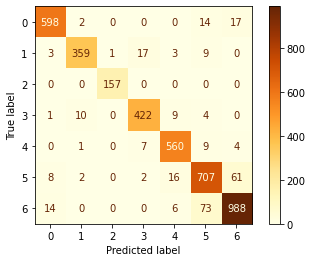

Confusion Matrix - normalised row-wise:


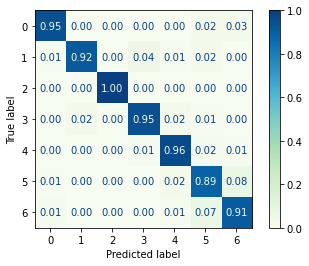

In [69]:
#choose a model to run (logistic, knn, decision tree, random forest)
#Random Forest gave best results
model_run = model_predictions("random_forest", X_train, X_test, y_train, y_test)

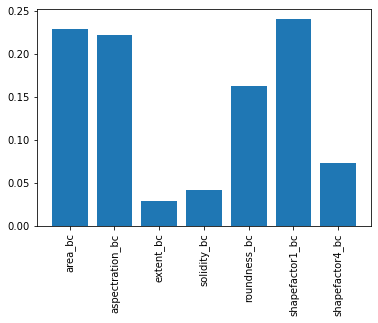

In [71]:
#checking feature importance for random forest classification
from sklearn.datasets import make_classification

model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance

   
# plot feature importance
pyplot.bar([x for x in X_train], importance)
plt.xticks(rotation='vertical')
plt.show()